## Long Range Transportation Plan

In [2]:
import _harmonization_utils as harmonization_utils
import _specific_list_utils as list_utils
import geopandas as gpd
import numpy as np
import pandas as pd
from calitp_data_analysis.sql import to_snakecase
from shared_utils import geography_utils, utils

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/home/jovyan/data-analyses/project_list/_sb1_utils.py:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migrati

In [3]:
pd.options.display.max_columns = 100
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

In [4]:
LRTP_GCS = f"{harmonization_utils.GCS_FILE_PATH}LRTP/"

### General Functions

In [5]:
def give_info(df, project_title: str, other_descriptive_col: str):
    print(df[project_title].value_counts().head())
    print(f"# of unique project titles: {df[project_title].nunique()}")
    print(
        f"After dropping duplicates using {project_title} and {other_descriptive_col}: {len(df.drop_duplicates(subset = [project_title, other_descriptive_col]))}"
    )
    print(f"Df shape: {df.shape}")
    print(df.columns)

In [6]:
def harmonizing_lrtp(
    df,
    project_name_col: str,
    project_description_col: str,
    project_category_col: str,
    project_cost_col: str,
    location_col: str,
    county_col: str,
    city_col: str,
    project_year_col: str,
    phase_col: str,
    program: str,
    data_source: str,
    note_cols: list,
    cost_in_millions: bool = True,
):
    """
    Take a dataset and change the column names/types to
    the same names and formats.
    """
    rename_columns = {
        project_name_col: "project_title",
        phase_col: "phase",
        project_description_col: "project_description",
        project_category_col: "project_category",
        project_cost_col: "total_project_cost",
        location_col: "geometry",
        county_col: "county",
        city_col: "city",
        project_year_col: "project_year",
    }
    # Rename columns
    df = df.rename(columns=rename_columns)

    # Coerce cost/fund columns to right type
    cost_columns = df.columns[df.columns.str.contains("(cost|funds)")].tolist()

    for i in cost_columns:
        df[i] = df[i].apply(pd.to_numeric, errors="coerce")

    # Add MPO & grant program
    df["lead_agency"] = program
    df["grant_program"] = f"{program} {data_source}"

    # Add data source
    df["data_source"] = program

    # Divide cost columns by millions
    # If bool is set to True
    if cost_in_millions:
        for i in cost_columns:
            df[i] = df[i].divide(1_000_000)

    # Fill in any nulls
    # df = df.fillna(df.dtypes.replace({"float64": 0.0, "object": "None"}))

    # Create columns even if they don't exist, just to harmonize
    # before concatting.
    create_columns = [
        "county",
        "city",
        "notes",
        "project_year",
        "project_category",
        "phase",
        
    ]
    
    for column in create_columns:
        if column not in df:
            df[column] = "None"
    if "geometry" not in df:
        df["geometry"] = None
    if "total_project_cost" not in df:
        df["total_project_cost"]: 0 
        
    # Create notes
    df = create_notes(df, note_cols)

    columns_to_keep = [
        "project_title",
        "lead_agency",
        "project_year",
        "project_category",
        "grant_program",
        "project_description",
        "phase",
        "total_project_cost",
        "geometry",
        "city",
        "county",
        "data_source",
        "notes",
    ]

    df = df[columns_to_keep]

    return df

In [7]:
def embedded_column_names(df, data_start: int) -> pd.DataFrame:
    """
    Some excel sheets have headers and column names
    embedded in the dataframe. Take them out.
    
    Args:
        data_start: the row number the column names begin.
    """
    # Delete header
    df = df.iloc[data_start:].reset_index(drop=True)
    # The first row contains column names - update it to the column
    df.columns = df.iloc[0]

    # Drop the first row as they are now column names
    df = df.drop(df.index[0]).reset_index(drop=True)

    return df

In [8]:
def create_notes(df, note_cols: list):
    """
    Combine mulitple columns together
    into a single column to minimize space.
    """
    prefix = "_"
    for column in note_cols:
        df[f"{prefix}{column}"] = df[column].astype(str)
    note_cols = [prefix + sub for sub in note_cols]

    # https://stackoverflow.com/questions/65532480/how-to-combine-column-names-and-values
    def combine_notes(x):
        return ", ".join([col + ": " + x[col] for col in note_cols])

    df["notes"] = df.apply(combine_notes, axis=1)
    df.notes = df.notes.str.replace("_", " ")

    return df

In [9]:
def open_rest_server(url_pt_1: str, url_pt_2: str, layer_name: list):
    """
    Open up data that is availably publicly via ArcGis
    """
    full_gdf = pd.DataFrame()
    for i in layer_name:
        gdf = to_snakecase(gpd.read_file(f"{url_pt_1}{i}{url_pt_2}"))
        gdf["layer_name"] = i
        full_gdf = pd.concat([full_gdf, gdf], axis=0)

    return full_gdf

In [10]:
def delete_embedded_headers(df, column: str, string_search: str) -> pd.DataFrame:
    """
    Some PDFS include the column names embedded mulitple times
    within the df. Delete them out.
    
    Example: Under the column 'description', delete the rows
    in which the value is 'description.' This signals that the row
    is just repeating the column name again.
    """
    headers = df[df[column].str.contains(string_search) == True]
    headers_index_list = headers.index.values.tolist()

    print(f"{len(headers_index_list)} rows are headers")

    df2 = df.drop(headers_index_list).reset_index(drop=True)
    return df2

In [11]:
def correct_project_cost(df, project_title_col: str, project_total_cost: str):
    """
    For some datasets, the same project
    (as determined by the same project name, cost,
    and source) is split across multiple rows.

    Ex: A project costs $500 million and is
    split on 5 rows by phase/location. Each row still lists
    the total  cost as $500 million, which is not accurate.
    This function will recalculate each of the row to list
    $100 mil as the total project cost
    """
    # Create a unique identifier
    df["unique_identifier"] = df[project_title_col] + df[project_total_cost].astype(str)

    # Create count for each project
    df["how_many_times_same_proj_appears"] = (
        df.groupby("unique_identifier").cumcount() + 1
    )

    # Find the total number of times a project title-cost appears.
    # Sort by descending and keep only the row with the highest level
    keep_cols = [project_title_col,
                "how_many_times_same_proj_appears",
                project_total_cost,
                "unique_identifier"]
    df2 = (df[keep_cols]
           .sort_values([project_title_col, "how_many_times_same_proj_appears"], ascending=False)
           .drop_duplicates(subset=["unique_identifier"])
          )
    
    # Create new funding estimate
    df2["new_proj_cost"] = (
        df2[project_total_cost] / df2["how_many_times_same_proj_appears"]
    )

    # Drop some columns
    df2 = df2.drop(
        columns=[
            project_title_col,
            project_total_cost,
            "how_many_times_same_proj_appears",
        ]
    )

    # Merge
    m1 = pd.merge(df, df2, how="inner", on="unique_identifier")

    # Clean up
    m1 = m1.drop(
        columns=[
            "unique_identifier",
            "how_many_times_same_proj_appears",
            project_total_cost,
        ]
    )
    m1[
        "total_project_cost_note"
    ] = "This is an estimate of how much the project cost, estimated by dividing the total project cost by how many times the project appears in the dataset."

    # Replace project cost
    m1 = m1.rename(columns={"new_proj_cost": "total_project_cost"})
    return m1

### Ambag

In [12]:
def ambag_lrtp():
    ambag1 = pd.read_excel(
        f"{LRTP_GCS}AMBAG_2045 Revenue Constrained Project List_Monterey County_by Project Type__022823.xlsx"
    )
    ambag2 = pd.read_excel(
        f"{LRTP_GCS}AMBAG_2045 Revenue Constrained Project List_San Benito County_by Project Type__022823.xlsx"
    )
    ambag3 = pd.read_excel(
        f"{LRTP_GCS}AMBAG_2045 Revenue Constrained Project List_Santa Cruz County_by Project Type__041923.xlsx"
    )

    # Move column names up
    ambag1 = embedded_column_names(ambag1, 1)
    ambag2 = embedded_column_names(ambag2, 1)
    ambag3 = embedded_column_names(ambag3, 1)

    # Add county
    ambag1["county"] = "Santa Cruz"
    ambag2["county"] = "Monterey"
    ambag3["county"] = "San Benito"

    # Conat & clean
    concat1 = pd.concat([ambag1, ambag2, ambag3], axis=0)
    concat1 = concat1.drop(columns=[2035.0, 2045.0, 2020.0, 2035.0])

    concat1 = to_snakecase(concat1)
    
    # Millions
    concat1["total_cost_millions"] = concat1["total_cost_\n_$_000s_"]* 1_000
    return concat1

In [13]:
ambag = ambag_lrtp()

In [14]:
give_info(ambag, "project", "project_description")

Citywide Bike Lanes                         2
The Alameda - Salinas Road Bike Route       2
Citywide Sidewalk Program                   2
Carmel to Pebble Beach Bike/Ped Facility    1
Second Street Bike Lane                     1
Name: project, dtype: int64
# of unique project titles: 277
After dropping duplicates using project and project_description: 280
Df shape: (280, 6)
Index(['ambag_id', 'project', 'project_description', 'total_cost_\n_$_000s_',
       'county', 'total_cost_millions'],
      dtype='object', name=0)


In [15]:
ambag.loc[ambag.project == "Citywide Bike Lanes"]

,ambag_id,project,project_description,total_cost_\n_$_000s_,county,total_cost_millions
133,MON-SOL075-SO,Citywide Bike Lanes,"Bike Lanes (2007 TIF M2, 2013 TIF M2); construct bike lanes citywide",1440,Santa Cruz,1440000
52,SC-SV-P41-SCV,Citywide Bike Lanes,Construction of additional bike lanes and paths citywide (including Green Hills).,2060,San Benito,2060000


In [16]:
def harmonize_ambag():
    df = ambag_lrtp()
    df = harmonizing_lrtp(
        df,
        project_name_col="project",
        project_description_col="project_description",
        project_category_col="",
        project_cost_col="total_cost_millions",
        location_col="",
        county_col="",
        city_col="",
        project_year_col="",
        program="AMBAG",
        phase_col="",
        data_source="LRTP",
        note_cols=["county"
        ],
        cost_in_millions=True,
    )

    return df

In [17]:
type(harmonize_ambag())

/tmp/ipykernel_236/632009538.py:36: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


pandas.core.frame.DataFrame

### BCAG 

In [18]:
def bcag_lrtp():
    """
    Project cost is in thousands
    """
    df = pd.read_excel(f"{LRTP_GCS}BCAG.xls")
    drop_columns = [
        2018,
        2020,
        2030,
        2035,
        2040,
        "EXEMPT CODE",
        "PM 1",
        "PM 2",
        "PM 3",
    ]

    df = df.drop(columns=drop_columns)
    df = to_snakecase(df)
    
    # Correct cost
    # df.cost_estimate = df.cost_estimate * 1_000
    df.fund_estimate = (
     df.fund_estimate
        .str.replace("$","")
        .str.replace(".","")
        .str.replace("million","")
        .apply(pd.to_numeric, errors="coerce") * 1_000_000)
    
    # create geometry
    df["geometry"] = gpd.GeoSeries.from_xy(
        df.x_coord, df.y_coord, crs=geography_utils.WGS84
    )
    # Same project is split across multiple rows. Divide out project cost
    df = correct_project_cost(df, "title", "cost_estimate")
    df = df.set_geometry("geometry")

    return df

In [19]:
bcag = bcag_lrtp()

/tmp/ipykernel_236/3493150503.py:24: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


In [20]:
give_info(bcag, "title", "total_project_cost")

Local Highway Bridge Program (HBP Grouped)            68
Highway Safety Improvement Program (HSIP Grouped)     19
SR 70 Passing Lanes (Segment 3)                        2
Eaton Rd Widening                                      2
Lincoln Blvd Class 2                                   2
Name: title, dtype: int64
# of unique project titles: 153
After dropping duplicates using title and total_project_cost: 228
Df shape: (250, 24)
Index(['rtp_id', 'agency', 'ftip', 'rtp', 'project_type', 'title',
       'project_descr', 'project_id', 'fund_source', 'fund_estimate', 'status',
       'y_coord', 'x_coord', 'target_fiscal_year', 'fund_source_1',
       'fund_source_2', 'source', 'title_vi', 'non_title_vi', 'ej', 'non_ej',
       'geometry', 'total_project_cost', 'total_project_cost_note'],
      dtype='object')


In [21]:
bcag.sample()

,rtp_id,agency,ftip,rtp,project_type,title,project_descr,project_id,fund_source,fund_estimate,status,y_coord,x_coord,target_fiscal_year,fund_source_1,fund_source_2,source,title_vi,non_title_vi,ej,non_ej,geometry,total_project_cost,total_project_cost_note
18,19,BCAG,-,RTP,Passenger Rail,Chico to Sacramento Inter-City Commuter Rail Service,"New inter-city commuter rail serving Oroville, Marysville, and Sacramento.",BCAG-TRANSIT-TBD-2020-2,CMAQ/TDA/TIRCP/LCTOP/LOCAL,5000000.00,Planned,39.51,-121.55,2030,CMAQ/TDA/TIRCP/LCTOP/LOCAL,-,2018 California State Rail Plan,Y,Y,Y,Y,POINT (-121.55208 39.51262),5000.00,"This is an estimate of how much the project cost, estimated by dividing the total project cost by how many times the project appears in the dataset."


In [22]:
def harmonize_bcag():
    df = bcag_lrtp()
    df = harmonizing_lrtp(
        df,
        project_name_col="title",
        project_description_col="project_descr",
        project_category_col="project_type",
        project_cost_col="total_project_cost",
        location_col="geometry",
        county_col="",
        city_col="",
        project_year_col="target_fiscal_year",
        program="BCAG",
        phase_col="status",
        data_source="LRTP",
        note_cols=["fund_source",
                   "agency",
                   "total_project_cost_note",
        ],
        cost_in_millions=True,
    )

    return df

In [23]:
type(harmonize_bcag())

/tmp/ipykernel_236/3493150503.py:24: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
/tmp/ipykernel_236/632009538.py:36: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


geopandas.geodataframe.GeoDataFrame

### Fresno COG

In [24]:
def fresnocog_lrtp():
    columns_to_drop = ["unnamed:_7", "unnamed:_8", "unnamed:_9"]
    df1 = to_snakecase(pd.read_excel(f"{LRTP_GCS}FRESNO_COG_UNconstrained.xlsx"))
    df1["financial_constraint"] = "unconstrained"

    df2 = to_snakecase(pd.read_excel(f"{LRTP_GCS}FRESNO_COG_Constrained.xlsx"))
    df2["financial_constraint"] = "constrained"

    concat1 = pd.concat([df1, df2], axis=0)
    concat1 = concat1.drop(columns=columns_to_drop)

    return concat1

In [25]:
fresno_cog = fresnocog_lrtp()

In [26]:
give_info(fresno_cog, "project_title", "estimated\ntotal_cost\n_$1,000_")

Herndon @ SR 99-Widen Undercrossing                            2
Willow-International to Copper Southbound: Widen to 3 Lanes    2
SHIELDS: GARFIELD to CHATEAU FRESNO                            2
Anchor Ave. Park Blvd to Adams                                 2
Adams Ave Reconstruction                                       2
Name: project_title, dtype: int64
# of unique project titles: 3128
After dropping duplicates using project_title and estimated
total_cost
_$1,000_: 3143
Df shape: (3147, 10)
Index(['agency', 'project_id', 'project_title', 'project_description',
       'project_type', 'estimated_open_to_traffic',
       'estimated\ntotal_cost\n_$1,000_', 'est__o2t_year',
       'est_total_project_cost', 'financial_constraint'],
      dtype='object')


In [27]:
fresno_cog.project_title = fresno_cog.project_title.fillna('None')

In [28]:
fresno_cog[fresno_cog.project_title.str.contains("Ventura, SR 41")]

,agency,project_id,project_title,project_description,project_type,estimated_open_to_traffic,"estimated\ntotal_cost\n_$1,000_",est__o2t_year,est_total_project_cost,financial_constraint
989,Fresno,FRE111312,"Ventura, SR 41 to SR 99 Widen from 4LU to 4 LD",Widen to 4 LN Divided Arterial,Streets & Roads - Capacity Increasing,2027-2031,3427.00,2028-01-01,3427000.00,constrained
2071,Fresno,FRE111312,"Ventura, SR 41 to SR 99 Widen from 4LU to 4 LD",Widen to 4 LN Divided Arterial(Measure C Project F in the Urban Regional Program),Streets & Roads-Capacity Increasing,2028,3427.00,NaT,NaN,constrained


In [29]:
def harmonize_fresnocog():
    df = fresnocog_lrtp()
    df = harmonizing_lrtp(
        df,
        project_name_col="project_title",
        project_description_col="project_description",
        project_category_col="project_type",
        project_cost_col="est_total_project_cost",
        location_col="",
        county_col="",
        city_col="",
        project_year_col="estimated_open_to_traffic",
        program="Fresno COG",
        phase_col="status",
        data_source="LRTP",
        note_cols=["financial_constraint",
        ],
        cost_in_millions=True,
    )

    return df

### KCAG

In [30]:
def kcag_lrtp():

    df = to_snakecase(pd.read_excel(f"{LRTP_GCS}KCAG.xlsx"))

    # No title column
    df["title"] = (df.category + "-" + df.description + "-" + df.location).fillna(
        "No Title"
    )

    # Some duplicates
    df = df.drop_duplicates(["location", "category", "description"]).reset_index(
        drop=True
    )
    
    # Create cost
    df['total_cost'] = 0 
    
    return df

In [31]:
kcag = kcag_lrtp()

In [32]:
give_info(kcag, "title", "description")

No Title                                          26
Proposed Improvements-Overlay-Claudia Drive        1
Proposed Improvements-Overlay-Grand Street         1
Proposed Improvements-Overlay-Linda Lee Circle     1
Proposed Improvements-Overlay-Newbridge Drive      1
Name: title, dtype: int64
# of unique project titles: 59
After dropping duplicates using title and description: 59
Df shape: (84, 9)
Index(['category', 'jurisdiction', 'state_route', 'post_mile', 'location',
       'project_limits', 'description', 'title', 'total_cost'],
      dtype='object')


In [33]:
kcag[kcag.title == "Proposed Improvements-Pavement Maintenance-Various Locations"]

,category,jurisdiction,state_route,post_mile,location,project_limits,description,title,total_cost
4,Proposed Improvements,CORCORAN,NaN,NaN,Various Locations,NaN,Pavement Maintenance,Proposed Improvements-Pavement Maintenance-Various Locations,0


In [34]:
def harmonize_kcag():
    df = kcag_lrtp()
    df = harmonizing_lrtp(
        df,
        project_name_col="title",
        project_description_col="description",
        project_category_col="category",
        project_cost_col="total_cost",
        location_col="",
        county_col="",
        city_col="",
        project_year_col="",
        program="KCAG",
        phase_col="status",
        data_source="LRTP",
        note_cols=["jurisdiction",
                   "state_route",
          
                   "post_mile",
                   "project_limits",
                   "location",
        ],
        cost_in_millions=True,
    )

    return df

In [35]:
type(harmonize_kcag())

/tmp/ipykernel_236/632009538.py:36: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


pandas.core.frame.DataFrame

### INCOMPLETE KernCog
* I don't have the data.

In [36]:
def kern_lrtp():
    sheets_list = [
    "part1","part2","part3"]
    
    dict_df = pd.read_excel(f"{LRTP_GCS}KERNCOG.xlsx", sheet_name=sheets_list)
    
    df1 = dict_df.get(sheets_list[0])
    df2 = dict_df.get(sheets_list[1])
    df3 = dict_df.get(sheets_list[2])
    
    concat1 = to_snakecase(pd.concat([df1,df2,df3], axis= 0))
    
    monetary_cols = ['yoe_w__new_revenue_in_$1000',
       'yoe_w_o_new_revenue_in_$1000', 'maint__inflation_savings_in_$1000']
    
    for i in monetary_cols:
        concat1[i] = concat1[i].str.replace(" ", "")
    
    concat1 = concat1[['agency', 'scope'] + monetary_cols]
    
    concat1 = concat1.dropna(subset = 'scope')
    
    concat1['title'] = concat1.agency.astype(str) + '-' + concat1.scope.astype(str)
    
    # Rows to delete 
    concat1 = concat1[~concat1.title.str.contains("(SHOPP|aviation|potential new funds)")].reset_index(drop = True)
    
    return concat1

In [37]:
# kern = kern_lrtp()

In [38]:
# give_info(kern, "title", "yoe_w__new_revenue_in_$1000")

In [39]:
# kern.loc[kern.title.str.contains("Route 184 2Rt 58")]

In [40]:
# kern.groupby(['title',"yoe_w__new_revenue_in_$1000"]).agg({'scope':'count'}).sort_values(['scope'], ascending = False)

### Madera CTC

In [41]:
def madera_lrtp():
    sheets_list = [
    "Streets and Roads",
    "Maintenance",
    "Safety",
    "ATP",
    "Public Transit",
    "Aviation",
    "ITS",
    "Unconstrained"]
    
    dict_df = pd.read_excel(f"{LRTP_GCS}Madera_CTC_cleaned.xlsx", sheet_name=sheets_list)
    df1 = dict_df.get(sheets_list[0])
    df2 = dict_df.get(sheets_list[1])
    df3 = dict_df.get(sheets_list[2])
    df4 = dict_df.get(sheets_list[3])
    df5 = dict_df.get(sheets_list[4])
    df6 = dict_df.get(sheets_list[5])
    df7 = dict_df.get(sheets_list[6])
    df8 = dict_df.get(sheets_list[7])
    
    concat1 = to_snakecase(pd.concat([df1,df2,df3,df4,df5,df6,df7,df8], axis= 0))
    
    concat1 = concat1.drop(columns = ['proje\nct_id'])
    return concat1

In [42]:
madera = madera_lrtp()

In [43]:
madera.groupby(['project_name','total_cost']).agg({'category':'count'}).sort_values('category', ascending = False).head()

,,category
project_name,total_cost,
Various,1000000,3
Avenue 12,10000000,3
Road 36,563000,3
Purchase Transit Vehicle,300000,3
Road 16,197000,2


In [44]:
give_info(madera, 'project_name','total_cost')

Various                            20
Avenue 12                          10
Avenue 9                            8
State Route 41                      6
Purchase Transit Van (Electric)     5
Name: project_name, dtype: int64
# of unique project titles: 515
After dropping duplicates using project_name and total_cost: 735
Df shape: (765, 8)
Index(['category', 'agency', 'project_name', 'location', 'project_id',
       'description', 'opening_year', 'total_cost'],
      dtype='object')


In [45]:
# madera[madera.project_name == "Various"]

In [46]:
madera[madera.project_name == "Avenue 12"].head()

,category,agency,project_name,location,project_id,description,opening_year,total_cost
46,Streets and Roads,Madera County,Avenue 12,Road 38 to Road 40,NaN,2 Lanes to 4 Lanes,2027.00,10000000
47,Streets and Roads,Madera County,Avenue 12,Road 40 to Riverwalk\nBlvd,NaN,2 Lanes to 6 Lanes,2027.00,10000000
48,Streets and Roads,Madera County,Avenue 12,Riverwalk Blvd to SR\n41,NaN,4 Lanes to 8 Lanes,2027.00,10000000
49,Streets and Roads,Madera County,Avenue 12,SR 41 To Flagbarn Rd,NaN,2 Lanes to 4 Lanes,2030.00,4250000
51,Streets and Roads,Madera County,Avenue 12,Road 30 1/2 to Road 36,NaN,2 Lanes to 4 Lanes,2030.00,21000000


In [47]:
def harmonize_madera():
    df = madera_lrtp()
    df = harmonizing_lrtp(
        df,
        project_name_col="project_name",
        project_description_col="description",
        project_category_col="category",
        project_cost_col="total_cost",
        location_col="",
        county_col="",
        city_col="",
        project_year_col="opening_year",
        program="Madera CTC",
        phase_col="",
        data_source="LRTP",
        note_cols=[
                   "location",
        ],
        cost_in_millions=True,
    )

    return df

In [48]:
type(harmonize_madera())

/tmp/ipykernel_236/632009538.py:36: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


pandas.core.frame.DataFrame

### MCAGOV

In [49]:
def mcagov_lrtp():

    df = to_snakecase(pd.read_excel(f"{LRTP_GCS}MCAGOV.xlsx"))

    df = df.dropna(subset=["title"]).reset_index(drop=True)
    
    # Millions
    df["total_cost_millions"] = df["total_cost\n_$1,000s_"]* 1_000
    return df

In [50]:
mcagov = mcagov_lrtp()

In [51]:
give_info(mcagov, "title", "total_cost\n_$1,000s_")

Bellevue Rd Realignment/Reconstruction    1
Minturn Road Rehabilitation               1
MCAG Vanpool Program (dibs)               1
Measure V Transit Free Ride Program       1
Planada Route Improvements                1
Name: title, dtype: int64
# of unique project titles: 108
After dropping duplicates using title and total_cost
_$1,000s_: 108
Df shape: (108, 8)
Index(['agency', 'title', 'limits_description', 'type', 'completion\nyear',
       'total_cost\n_$1,000s_', 'funding_sources', 'total_cost_millions'],
      dtype='object')


In [52]:
mcagov.sample()

,agency,title,limits_description,type,completion\nyear,"total_cost\n_$1,000s_",funding_sources,total_cost_millions
106,Caltrans,"SR-99 ""Atwater Widening"" (4F to 6F)","In and near the City of Atwater, widen Route 99 from 4 to 6 lanes from 1.04 mile north of Applegate Road Overcrossing and 1.9 mile south of Applegate Road Overcrossing",Road Capacity,2035,220000,"SB-1, STIP",220000000


In [53]:
def harmonize_mcagov():
    df = mcagov_lrtp()
    df = harmonizing_lrtp(
        df,
        project_name_col="title",
        project_description_col="limits_description",
        project_category_col="type",
        project_cost_col="total_cost_millions",
        location_col="",
        county_col="",
        city_col="",
        project_year_col="completion\nyear",
        program="MCAGOV",
        phase_col="",
        data_source="LRTP",
        note_cols=["agency",
                   "funding_sources",
        ],
        cost_in_millions=True,
    )

    return df

In [54]:
type(harmonize_mcagov())

/tmp/ipykernel_236/632009538.py:36: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


pandas.core.frame.DataFrame

### MTC
* 133 projects but point and line map returns 240 ish rows.
* Projects that are in different locations can have the same name split by open year...
* I guess the geospatial projects are split into various phases while the regular pandas df is just the project in its entirety.
* https://www.planbayarea.org/2050-plan/final-plan-bay-area-2050/final-supplemental-reports/interactive-transportation-project-list
* https://opendata.mtc.ca.gov/datasets/MTC::2023-transportation-improvement-program-projects-point/about
* https://opendata.mtc.ca.gov/datasets/MTC::plan-bay-area-2050-transportation-projects-line/about
* https://data.bayareametro.gov/Projects/Plan-Bay-Area-2050-Transportation-Project-List/y7ka-jksz

In [55]:
def mtc_lrtp():
    # Open rest server data
    layer_list = ["planbayarea2050_rtp_line", "planbayarea2050_rtp_point"]
    url_pt_1 = "https://services3.arcgis.com/i2dkYWmb4wHvYPda/ArcGIS/rest/services/"
    url_pt_2 = "/FeatureServer/0/query?where=1%3D1&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&resultType=none&distance=0.0&units=esriSRUnit_Meter&relationParam=&returnGeodetic=false&outFields=*+&returnGeometry=true&featureEncoding=esriDefault&multipatchOption=xyFootprint&maxAllowableOffset=&geometryPrecision=&outSR=&defaultSR=&datumTransformation=&applyVCSProjection=false&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&returnQueryGeometry=false&returnDistinctValues=false&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&returnZ=false&returnM=false&returnExceededLimitFeatures=true&quantizationParameters=&sqlFormat=none&f=pgeojson&token="
    gdf = open_rest_server(url_pt_1, url_pt_2, layer_list)

    # Open all MTC projects. Not all projects are mappable.
    all_projects_url = "https://data.bayareametro.gov/resource/y7ka-jksz.json?$query=SELECT%0A%20%20%60plan_strategy%60%2C%0A%20%20%60rtpid%60%2C%0A%20%20%60title%60%2C%0A%20%20%60scope%60%2C%0A%20%20%60open_period%60%2C%0A%20%20%60funding_millions_yoe%60%2C%0A%20%20%60county%60"
    all_projects = pd.read_json(all_projects_url)

    # Merge info from all projects to gdf
    gdf = pd.merge(
        gdf, all_projects, how="inner", left_on=["proj_title"], right_on=["title"]
    )

    gdf = gdf.drop(columns=["title"])

    # Find projects that are unmappable
    mtc_geometry_titles = set(gdf.proj_title.unique().tolist())
    mtc_all_projects_titles = set(all_projects.title.unique().tolist())
    missing_projects = list(mtc_all_projects_titles - mtc_geometry_titles)

    # Add back in the  unmappable projects
    all_projects = all_projects[all_projects.title.isin(missing_projects)].reset_index(
        drop=True
    )
    all_projects = all_projects.rename(columns={"title": "proj_title"})
    final = pd.concat([all_projects, gdf])

    # Correct typo
    final = final.rename({"mode detai": "mode_detail"})

    # Set geometry again
    final = final.set_geometry("geometry").set_crs(geography_utils.WGS84)

    # Same project is split across multiple rows. Divide out project cost
    final = correct_project_cost(final, "proj_title", "funding_millions_yoe")
    return final

In [56]:
mtc_og = mtc_lrtp()

/opt/conda/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).


In [57]:
give_info(mtc_og, "proj_title", "total_project_cost")

Minor Roadway Improvements | Regional                                           36
Express Lanes | Regional                                                        32
Other Investments to Expand & Modernize the Regional Rail Network | Regional    15
Bay Area Forward Program | Regional                                              8
Rapid Bus | AC Transit | Modernization                                           8
Name: proj_title, dtype: int64
# of unique project titles: 133
After dropping duplicates using proj_title and total_project_cost: 133
Df shape: (282, 20)
Index(['plan_strategy', 'rtpid', 'proj_title', 'scope', 'open_period',
       'county', 'objectid', 'map_id', 'subcompone', 'open_year', 'strategy',
       'rtp_id', 'mode_', 'mode_detai', 'investment', 'shape__length',
       'geometry', 'layer_name', 'total_project_cost',
       'total_project_cost_note'],
      dtype='object')


In [58]:
def harmonize_mtc():
    df = mtc_lrtp()
    df = harmonizing_lrtp(
        df,
        project_name_col="proj_title",
        project_description_col="subcompone",
        project_category_col="plan_strategy",
        project_cost_col="funding_millions_yoe",
        location_col="geometry",
        county_col="county",
        city_col="",
        project_year_col="open_year",
        phase_col="",
        program="MTC",
        data_source="LRTP",
        note_cols=[
            "strategy",
            "layer_name",
            "mode_detai",
        ],
        cost_in_millions=False,
    )

    return df

In [59]:
harmonized_mtc = harmonize_mtc()

/opt/conda/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
/tmp/ipykernel_236/632009538.py:36: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


### Sacramento Area Council of Governments (SACOG)
* https://www.sacog.org/sites/main/files/file-attachments/2020_mtp-scs.pdf?1580330993

In [60]:
# sacog = to_snakecase(gpd.read_file("https://services.sacog.org/hosting/rest/services/Hosted/2040_Major_Stops/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson"))

In [61]:
def sacog_lrtp():

    df = to_snakecase(pd.read_excel(f"{LRTP_GCS}SACOG.xlsx"))

    # Delete embedded headers
    df = delete_embedded_headers(df, "description", "Description")

    # Delete columns with all nulls
    df = df.dropna(axis=1, how="all")

    # Drop duplicates
    df = df.drop_duplicates().reset_index(drop=True)
    
    return df

In [62]:
sacog = sacog_lrtp()

96 rows are headers


In [63]:
give_info(sacog, "title", "description")

Safety Improvements                            2
Connect Card Implementation                    2
Aux Lane Project: EB Latrobe Road              1
Bus Maintenance Facility #1 Rehabilitation     1
Enhanced Employee Protection Warning System    1
Name: title, dtype: int64
# of unique project titles: 1599
After dropping duplicates using title and description: 1601
Df shape: (1601, 10)
Index(['id', 'status__planned,_programmed_or_project_development_only_',
       'county', 'lead_agency', 'budget_category', 'title', 'description',
       'total_project_cost__2018_dollars_',
       'year_of_expenditure_cost_for_planned_projects', 'completion_timing'],
      dtype='object')


In [64]:
def harmonize_sacog():
    df = sacog_lrtp()
    df = harmonizing_lrtp(
        df,
        project_name_col="title",
        project_description_col="description",
        project_category_col="budget_category",
        project_cost_col="total_project_cost__2018_dollars_",
        location_col="",
        county_col="county",
        city_col="",
        project_year_col="completion_timing",
        program="SACOG",
        phase_col="",
        data_source="LRTP",
        note_cols=[
            "year_of_expenditure_cost_for_planned_projects",
            "status__planned,_programmed_or_project_development_only_",
        ],
        cost_in_millions=True,
    )

    return df

In [65]:
df = to_snakecase(pd.read_excel(f"{LRTP_GCS}SACOG.xlsx"))

### SANDAG
* https://www.arcgis.com/home/item.html?id=ba8b2a6247ef463cb7411f039959f3ee
* https://www.arcgis.com/apps/mapviewer/index.html?webmap=ba8b2a6247ef463cb7411f039959f3ee

In [66]:
columns_to_keep = [
    "project_title",
    "lead_agency",
    "project_year",
    "project_category",
    "grant_program",
    "project_description",
    "total_project_cost",
    "location",
    "city",
    "county",
    "data_source",
    "notes",
]

In [67]:
def sandag_lrtp():
    sandag_layers_list = [
        "Complete_Corridors_Connectors_Intersections_Ramps_RP2021",
        "Complete_Corridors_Highway_RP2021",
        "Transit_Leap_RP2021",
        "Adopted_Regional_Bike_Network_RP2021",
        "Mobility_Hubs_and_Flexible_Fleets",
        "Complete_Corridors_Regional_Arterials",
        "Goods_Movement",
    ]

    sandag_url_pt1 = (
        "https://services1.arcgis.com/HG80xaIVT1z1OdO5/ArcGIS/rest/services/"
    )
    sandag_url_pt2 = "/FeatureServer/0/query?where=1%3D1&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&resultType=none&distance=0.0&units=esriSRUnit_Meter&relationParam=&returnGeodetic=false&outFields=*+&returnGeometry=true&featureEncoding=esriDefault&multipatchOption=xyFootprint&maxAllowableOffset=&geometryPrecision=&outSR=&defaultSR=&datumTransformation=&applyVCSProjection=false&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&returnQueryGeometry=false&returnDistinctValues=false&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&returnZ=false&returnM=false&returnExceededLimitFeatures=true&quantizationParameters=&sqlFormat=none&f=pgeojson&token="
    sandag = open_rest_server(sandag_url_pt1, sandag_url_pt2, sandag_layers_list)

    # Same project is split across multiple rows. Divide out project cost
    sandag.cost2020m = (
        sandag.cost2020m.str.replace("$", "")
        .str.replace("N/A", "")
        .apply(pd.to_numeric, errors="coerce")
    )
    sandag = correct_project_cost(sandag, "project_name", "cost2020m")

    return sandag

In [68]:
sandag = sandag_lrtp()

/tmp/ipykernel_236/3788115394.py:20: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


In [69]:
sandag.loc[sandag.project_name == "I-15 (SR 52)"][
    ["project_name", "total_project_cost", "description"]
]

,project_name,total_project_cost,description
5,I-15 (SR 52),181.00,West to North and South to East
41,I-15 (SR 52),65.33,North to West and East to South
42,I-15 (SR 52),65.33,North to East and West to South
43,I-15 (SR 52),65.33,South to West and East to North


In [70]:
give_info(sandag, "project_name", "total_project_cost")

N/A                  22
I-15 (I-8)            4
I-15 (SR 52)          4
I-805 (I-8)           4
Commuter Rail 398     3
Name: project_name, dtype: int64
# of unique project titles: 309
After dropping duplicates using project_name and total_project_cost: 315
Df shape: (416, 55)
Index(['objectid', 'type', 'freeway', 'intersecti', 'caption', 'project_id',
       'phase', 'direction', 'project_id_1', 'year_built', 'category',
       'project_name', 'description', 'aqc_2016_1', 'aqc_2020_1', 'pricmcp',
       'conncmcp', 'status', 'categoría', 'corredor', 'nombre_del_proyecto',
       'descripción', 'corredores_de_conexión', 'geometry', 'layer_name',
       'corridor_i', 'type_1', 'existing', 'limits', 'description_1',
       'shape__length', 'route', 'routetype', 'route_desc', 'rp_2021_id',
       'rp_2021_id_1', 'primary_corridor', 'connecting_corridor_s_',
       'capital_cost___2020__millions', 'name', 'mohubtype', 'mohubsize',
       'transitservices', 'globalid', 'icon_url', 'shape__a

In [71]:
def harmonize_sandag():
    df = sandag_lrtp()
    df = harmonizing_lrtp(
        df,
        project_name_col="project_name",
        project_description_col="description",
        project_category_col="category",
        project_cost_col="cost2020m",
        location_col="geometry",
        county_col="",
        city_col="",
        project_year_col="phase",
        phase_col="status",
        program="SANDAG",
        data_source="LRTP",
        note_cols=[
            "aqc_2016_1",
            "aqc_2020_1",
            "pricmcp",
            "conncmcp",
            "layer_name",
            "corridor_i",
            "type_1",
            "existing",
            "limits",
            "description_1",
            "route",
            "routetype",
            "route_desc",
            "rp_2021_id",
            "rp_2021_id_1",
            "capital_cost___2020__millions",
        ],
        cost_in_millions=False,
    )

    return df

### SBCAG

In [72]:
def sbcag_lrtp():

    df = to_snakecase(pd.read_excel(f"{LRTP_GCS}SBCAG.xlsx"))
    drop_columns = [
        "unnamed:_2",
        "project_type",
        "unnamed:_4",
        "unnamed:_6",
        "unnamed:_8",
        "unnamed:_9",
        "unnamed:_10",
        "unnamed:_13",
    ]
    df = df.drop(columns=drop_columns)
    df = delete_embedded_headers(df, "description", "Description")
    df = df.dropna(subset=["description"]).reset_index(drop=True)

    df = df.drop_duplicates(
        subset=["phase", "project_title", "phase", "total_cost__$000s_"]
    ).reset_index(drop=True)
    
    # Millions
    df["total_cost_millions"] = df["total_cost__$000s_"]* 1_000
    
    return df

In [73]:
sbcag = sbcag_lrtp()

65 rows are headers


In [74]:
give_info(sbcag, "project_title", "total_cost__$000s_")

SB-PL-15: Upper De la Vina St Gap Closure and Safe Crossings              2
CT-1: SR 246 Passing Lanes – Planting Mitigation (FTIP CT93)(EA 0C641)    1
SM-PL-10: A Street Widening                                               1
Sol-PL-6: Fredensborg Canyon Rd/Adobe Creek Culvert Replacement           1
Sol-PL-5: Solvang School Sidewalk Project                                 1
Name: project_title, dtype: int64
# of unique project titles: 418
After dropping duplicates using project_title and total_cost__$000s_: 419
Df shape: (419, 8)
Index(['type', 'project_title', 'phase', 'description',
       'primary_funding_source_s_', 'year', 'total_cost__$000s_',
       'total_cost_millions'],
      dtype='object')


In [75]:
sbcag.sample()

,type,project_title,phase,description,primary_funding_source_s_,year,total_cost__$000s_,total_cost_millions
152,Programmed,SBCAG-13: Freeway Service Patrol (FSP),Support,A fleet of tow and pickup trucks patrol designated portions (beats) of freeways during morning and afternoon commute hours clearing accidents and removing\ndebris.,NaN,Ongoing,7270,7270000


In [76]:
def harmonize_sbcag():
    df = sbcag_lrtp()
    df = harmonizing_lrtp(
        df,
        project_name_col="project_title",
        project_description_col="description",
        project_category_col="phase",
        project_cost_col="total_cost_millions",
        location_col="",
        county_col="",
        city_col="",
        project_year_col="completion\nyear",
        program="SBCAG",
        phase_col="",
        data_source="LRTP",
        note_cols=["type",
                   "primary_funding_source_s_",
                   "year",
        ],
        cost_in_millions=True,
    )

    return df

### INCOMPLETE Shasta County Regional Transportation Planning Agency (SCRTPA)

### INCOMPLETE San Luis Obispo Council of Governments (SLOCOG)
* Have to paste the data from the word doc and merge with shapefiles, which I'll receive on Monday.

In [ ]:
def slocog_lrtp():
    df = to_snakecase(pd.read_excel(f"{LRTP_GCS}SLOCOG.xlsx"))

In [78]:
df = to_snakecase(pd.read_excel(f"{LRTP_GCS}SLOCOG.xlsx"))

In [80]:
df['total_cost'] = df._2021_cost_estimate

In [82]:
df.total_cost = df.fillna(df["_2045\ntotal_capital_cost"])

ValueError: Columns must be same length as key

###  SJCOG

In [77]:
def sjcog_lrtp():
    sheets_list = [
        "1 Mainline",
        "2 Interchanges",
        "3 Reg Roadways",
        "4 RR Xings",
        "5 Bus Transit",
        "6 Rail Corridor",
        "7 Airports",
        "8 Active Trans Facilities",
        "9 TCMs",
        "10 Ops & Maint",
    ]
    dict_df = pd.read_excel(f"{LRTP_GCS}SJCOG.xlsx", sheet_name=sheets_list)
    df1 = to_snakecase(dict_df.get("1 Mainline"))
    df2 = to_snakecase(dict_df.get("2 Interchanges"))
    df3 = to_snakecase(dict_df.get("3 Reg Roadways"))
    df4 = to_snakecase(dict_df.get("4 RR Xings"))
    df5 = to_snakecase(dict_df.get("5 Bus Transit"))
    df6 = to_snakecase(dict_df.get("6 Rail Corridor"))
    df7 = to_snakecase(dict_df.get("7 Airports"))
    df8 = to_snakecase(dict_df.get("8 Active Trans Facilities"))
    df9 = to_snakecase(dict_df.get("9 TCMs"))
    df10 = to_snakecase(dict_df.get("10 Ops & Maint"))

    concat1 = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10], axis=0)

    sjcog_cols = [
        "_2018_rtp_mpo_id",
        "ctips_id_#",
        "jurisdiction",
        "facility_name_route",
        "project_description",
        "project_limits",
        "total",
        "ftip_programming",
        "nepa_approval",
        "open_to_traffic",
        "completion",
        "completion_date",
        "facility_name_route_1",
        "project_description_1",
        "milestone_years_1",
        "project_name",
    ]

    concat1 = concat1.dropna(
        subset=[
            "project_description",
            "_2018_rtp_mpo_id",
        ]
    ).reset_index(drop=True)

    # Some projects have no titles, create them manually
    concat1["title_manual"] = (
        concat1.project_limits
        + "-"
        + concat1.jurisdiction
        + "-"
        + concat1.facility_name_route
    ) 
    concat1.title_manual = concat1.title_manual.fillna("No Title")
    concat1.project_name = concat1.project_name.fillna(concat1.title_manual)

    concat1 = concat1[sjcog_cols]

    return concat1

In [78]:
sjcog = sjcog_lrtp()

In [79]:
give_info(sjcog, "project_name", "total")

City of Lodi-Lodi-Grapeline Capital                                                                         8
Various-Caltrans-Various locations                                                                          8
No Title                                                                                                    8
City streets, various locations-Stockton-Regional Surface Transportation Program (STP) Lump Sum Projects    2
Along Northwest side of I-5 from Brookhurst Blvd to Stewart Road-Lathrop-Golden Valley Parkway              2
Name: project_name, dtype: int64
# of unique project titles: 236
After dropping duplicates using project_name and total: 255
Df shape: (262, 16)
Index(['_2018_rtp_mpo_id', 'ctips_id_#', 'jurisdiction', 'facility_name_route',
       'project_description', 'project_limits', 'total', 'ftip_programming',
       'nepa_approval', 'open_to_traffic', 'completion', 'completion_date',
       'facility_name_route_1', 'project_description_1', 'milestone_year

In [80]:
sjcog.sample()

,_2018_rtp_mpo_id,ctips_id_#,jurisdiction,facility_name_route,project_description,project_limits,total,ftip_programming,nepa_approval,open_to_traffic,completion,completion_date,facility_name_route_1,project_description_1,milestone_years_1,project_name
183,SJ14-7020,NaN,Tracy,Tracy Municipal Airport,Aircraft Wash Facility,NaN,NaN,NaN,NaN,NaN,2022.00,NaN,NaN,98000.00,NaN,No Title


In [81]:
def harmonize_sjcog():
    df = sjcog_lrtp()
    df = harmonizing_lrtp(
        df,
        project_name_col="project_name",
        project_description_col="project_description",
        project_category_col="",
        project_cost_col="total",
        location_col="",
        county_col="",
        city_col="",
        project_year_col="completion_date",
        program="SJCOG",
        phase_col="",
        data_source="LRTP",
        note_cols=['jurisdiction', 'facility_name_route',
       'project_limits', 'ftip_programming',
       'nepa_approval', 'open_to_traffic', 'completion',
       'facility_name_route_1', 'project_description_1', 'milestone_years_1',
],
        cost_in_millions=True,
    )

    return df

In [82]:
type(harmonize_sjcog())

/tmp/ipykernel_1324/632009538.py:36: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


pandas.core.frame.DataFrame

### Southern California Association of Governments (SCAG) 

In [83]:
def scag_lrtp():
    sheets_list = ["Table 1", "Table 2"]
    dict_df = pd.read_excel(f"{LRTP_GCS}SCAG.xlsx", sheet_name=sheets_list)

    df1 = to_snakecase(dict_df.get("Table 1"))
    # Drop columns where everything is NA
    df1 = df1.dropna(axis=1, how="all")

    df2 = to_snakecase(dict_df.get("Table 2"))
    df2 = df2.dropna(axis=1, how="all")

    # Concat
    df3 = pd.concat([df1, df2])

    df4 = delete_embedded_headers(df3, "rtp_id", "RTP ID")

    df4 = df4.dropna(
        subset=["description", "lead_agency", "project_cost__$1,000s_"]
    ).reset_index(drop=True)

    # No project title - create one
    df4["project_title"] = (df4.description + "-" + df4.lead_agency).fillna("No Title")

    # Project cost is in thousands.
    # Multiple out
    df4["project_cost_millions"] = df4["project_cost__$1,000s_"] * 1_000
    return df4

In [84]:
scag = scag_lrtp()

360 rows are headers


In [85]:
give_info(scag, "project_title", "route_name")

WIDEN FROM 2 TO 4 LANES-RIVERSIDE COUNTY      34
WIDEN FROM 2 TO 4 LANES-PERRIS                24
WIDEN FROM 2 TO 6 LANES-RIVERSIDE COUNTY      20
WIDEN FROM 2 TO 4 LANES-DESERT HOT SPRINGS    18
WIDEN FROM 4 TO 6 LANES-PALM DESERT           17
Name: project_title, dtype: int64
# of unique project titles: 2668
After dropping duplicates using project_title and route_name: 2850
Df shape: (2952, 13)
Index(['system', 'lead_agency', 'rtp_id', 'route_#', 'route_name', 'from',
       'to', 'description', 'completion_year', 'project_cost__$1,000s_',
       'county', 'project_title', 'project_cost_millions'],
      dtype='object')


In [86]:
def harmonize_scag():
    df = scag_lrtp()
    df = harmonizing_lrtp(
        df,
        project_name_col="project_title",
        project_description_col="description",
        project_category_col="system",
        project_cost_col="project_cost_millions",
        location_col="",
        county_col="county",
        city_col="",
        project_year_col="completion_year",
        program="SCAG",
        phase_col="",
        data_source="LRTP",
        note_cols=["lead_agency", "route_#", "route_name", "from", "to"],
        cost_in_millions=True,
    )

    return df

In [87]:
scag_harmonized = harmonize_scag()

360 rows are headers


/tmp/ipykernel_1324/632009538.py:36: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


In [88]:
# scag.head()

In [89]:
# scag_harmonized.head()

### Stancog

In [90]:
def stancog_lrtp():

    df = to_snakecase(pd.read_excel(f"{LRTP_GCS}STANCOG.xlsx"))
    df = embedded_column_names(df, 1)
    keep_columns = [
        "Jurisdiction",
        "Location",
        "Project Limits",
        "Description",
        "Total Cost",
        "Open to Traffic",
        "Funding Source",
        "System Preserv.",
        "Capacity Enhance.",
        "Safety",
        "Oper.",
        "Complete Streets",
        "Active\nTransporta tion",
        "Transit",
        "Other",
    ]

    df = df[keep_columns]

    df = to_snakecase(df)

    df = df.dropna(subset=["description"]).reset_index(drop=True)

    df["title"] = (df.location + "-" + df.description).fillna("No Title")

    df = delete_embedded_headers(df, "location", "Location")

    df = df.drop_duplicates(
        subset=["title", "location", "jurisdiction", "total_cost", "open_to_traffic"]
    ).reset_index(drop=True)
    return df

In [91]:
stancog = stancog_lrtp()

68 rows are headers


In [92]:
give_info(stancog, "title", "total_cost")

Whitmore Ave-Install Traffic Signal                   5
No Title                                              5
W. Main St-Widen to 3 lanes                           4
SR-99-Construct NB & SB auxiliary lanes               4
SR-33-Install 4 Lane Arterial Roadway Improvements    3
Name: title, dtype: int64
# of unique project titles: 515
After dropping duplicates using title and total_cost: 552
Df shape: (556, 16)
Index(['jurisdiction', 'location', 'project_limits', 'description',
       'total_cost', 'open_to_traffic', 'funding_source', 'system_preserv_',
       'capacity_enhance_', 'safety', 'oper_', 'complete_streets',
       'active\ntransporta_tion', 'transit', 'other', 'title'],
      dtype='object', name=0)


In [93]:
stancog.sample()

,jurisdiction,location,project_limits,description,total_cost,open_to_traffic,funding_source,system_preserv_,capacity_enhance_,safety,oper_,complete_streets,active\ntransporta_tion,transit,other,title
399,Stanislaus County,Stanislaus River Trail,630 ft NE of Stanislaus River Court/Stanislaus River Drive to Sonora Rd,Class 1 Path. New Construction. StanCOG Non-Motorized Transportation Master Plan Project ID: STAN-1C,6270300,2022-2046,"ATP, SB 1, BIL/IIJA, CMAQ, STBGP",NaN,NaN,NaN,NaN,NaN,X,NaN,NaN,Stanislaus River Trail-Class 1 Path. New Construction. StanCOG Non-Motorized Transportation Master Plan Project ID: STAN-1C


In [94]:
def harmonize_stancog():
    df = stancog_lrtp()
    df = harmonizing_lrtp(
        df,
        project_name_col="title",
        project_description_col="description",
        project_category_col="",
        project_cost_col="total_cost",
        location_col="",
        county_col="",
        city_col="",
        project_year_col="open_to_traffic",
        program="STANCOG",
        phase_col="",
        data_source="LRTP",
        note_cols=['jurisdiction', 'location', 'project_limits',
                   'funding_source', 'system_preserv_',
       'capacity_enhance_', 'safety', 'oper_', 'complete_streets',
       'active\ntransporta_tion', 'transit', 'other',],
        cost_in_millions=True,
    )

    return df

In [95]:
type(harmonize_stancog())

68 rows are headers


/tmp/ipykernel_1324/632009538.py:36: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


pandas.core.frame.DataFrame

### TMPO (Tahoe)
* Open data portal: https://www.tahoeopendata.org/search?tags=transportation
* https://www.tahoeopendata.org/datasets/TRPA::2020-regional-transportation-plan-projects/about

In [96]:
def tmpo_lrtp():
    tahoe_url = "https://maps.trpa.org/server/rest/services/Datadownloader_Transportation/MapServer/19/query?where=1%3D1&text=&objectIds=&time=&timeRelation=esriTimeRelationOverlaps&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&distance=&units=esriSRUnit_Foot&relationParam=&outFields=*+&returnGeometry=true&returnTrueCurves=false&maxAllowableOffset=&geometryPrecision=&outSR=&havingClause=&returnIdsOnly=false&returnCountOnly=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&returnZ=false&returnM=false&gdbVersion=&historicMoment=&returnDistinctValues=false&resultOffset=&resultRecordCount=&returnExtentOnly=false&sqlFormat=none&datumTransformation=&parameterValues=&rangeValues=&quantizationParameters=&featureEncoding=esriDefault&f=geojson"
    gdf = to_snakecase(gpd.read_file(tahoe_url))
    gdf.complete_year = gdf.complete_year.astype(int)

    # Filter out projects that are not yet completed
    gdf2 = gdf[gdf.complete_year > 2022].reset_index(drop=True)

    gdf2["project_year"] = (
        gdf2.start_year.astype(str) + "-" + gdf.complete_year.astype(str)
    )
    return gdf2

In [97]:
tahoe = tmpo_lrtp()

In [98]:
tahoe[['project_name','total_cost']].sort_values(['project_name']).head()

,project_name,total_cost
34,Adaptive Traffic Management on US 50,
19,Alta Mira Public Access Improvements,
73,Apache Avenue Pedestrian Safety and Connectivity Project,
70,Brockway Vista Multi-Use Trail,
65,California Multi-Modal Signal Control Optimization,


In [99]:
def harmonize_tahoe():
    df = tmpo_lrtp()
    df = harmonizing_lrtp(
        df,
        project_name_col="project_name",
        project_description_col="description",
        project_category_col="category",
        project_cost_col="estimated_cost",
        location_col="geometry",
        county_col="",
        city_col="",
        project_year_col="project_year",
        program="TMPO",
        phase_col="phase",
        data_source="LRTP",
        note_cols=[
            "implementer",
            "funding_type",
            "plan_name",
            "label",
            "financial_status",
            "url",
        ],
        cost_in_millions=True,
    )

    return df

### TCAG

In [100]:
def tcag_lrtp():
    df = to_snakecase(pd.read_excel(f"{LRTP_GCS}TCAG.xlsx"))

    def completion_2035(row):
        if row.completed_by_2035_y_n == "Y":
            return "2035"

    df["completion_year"] = df.apply(lambda x: completion_2035(x), axis=1)
    
    df['cost_in_millions'] = df['cost_x_1,000']*1_000
    return df

In [101]:
tcag = tcag_lrtp()

In [102]:
tcag.groupby(["project_title", "cost_x_1,000"]).agg({'project_category':'count'}).sort_values('project_category', ascending = False).head()

,,project_category
project_title,"cost_x_1,000",
Bike/Ped Improvements next 9 years,0.00,6
Bike/Ped Improvements next 9 yrs second half of measure R,500.00,3
Avenue 316 Construct new roadway,6500.00,3
Bike/Ped Improvements next 9 yrs second half of measure R,226.00,2
Transit Center Minor,300.00,2


In [103]:
give_info(tcag, "project_title", "cost_x_1,000")

Bike/Ped Improvements next 9 yrs second half of measure R    9
Bike/Ped Improvements next 9 years                           9
Purchase Buses                                               4
SR 99 Widen existing roadway                                 4
Riggin Avenue Widen existing roadway                         4
Name: project_title, dtype: int64
# of unique project titles: 272
After dropping duplicates using project_title and cost_x_1,000: 321
Df shape: (340, 13)
Index(['project_id__if_applicable_', 'jurisdiction', 'project_title',
       'project_description', 'project_category', 'completed_by_2035_y_n',
       'local', 'regional', 'state', 'federal', 'cost_x_1,000',
       'completion_year', 'cost_in_millions'],
      dtype='object')


In [104]:
tcag[tcag.project_title == "Bike/Ped Improvements next 9 yrs second half of measure R"].head(2)

,project_id__if_applicable_,jurisdiction,project_title,project_description,project_category,completed_by_2035_y_n,local,regional,state,federal,"cost_x_1,000",completion_year,cost_in_millions
61,NaN,Dinuba,Bike/Ped Improvements next 9 yrs second half of measure R,"used $49,000 for alta heritage; $50K used for El Monte Way,",Active Transportation,Y,NaN,X,NaN,NaN,226.00,2035,226000.00
62,NaN,Exeter,Bike/Ped Improvements next 9 yrs second half of measure R,"Used $485,980. on Belmont Project",Active Transportation,Y,NaN,X,NaN,NaN,14.02,2035,14020.00


In [105]:
def harmonize_tcag():
    df = tcag_lrtp()
    df = harmonizing_lrtp(
        df,
        project_name_col="project_title",
        project_description_col="project_description",
        project_category_col="project_category",
        project_cost_col="cost_in_millions",
        location_col="",
        county_col="",
        city_col="",
        project_year_col="completion_year",
        program="TCAG",
        phase_col="",
        data_source="LRTP",
        note_cols=['jurisdiction', 'local','regional','federal','state'],
        cost_in_millions=True,
    )

    return df

In [106]:
type(harmonize_tcag())

/tmp/ipykernel_1324/632009538.py:36: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


pandas.core.frame.DataFrame

## Congestion

#### Lost

In [107]:
lost = harmonization_utils.load_lost()

In [108]:
def harmonize_lost():
    df = harmonization_utils.load_lost()
    df = harmonizing_lrtp(
        df,
        project_name_col="project_title",
        project_description_col="project_description",
        project_category_col="project_category",
        project_cost_col="cost__in_millions_",
        location_col="",
        county_col="county",
        city_col="city",
        project_year_col="",
        program="LOST",
        phase_col="phase",
        data_source="LOST",
        note_cols=[
            "measure",
            "estimated_lost_funds",
            "estimated_federal_funds",
            "estimated_state_funds",
            "estimated_local_funds",
            "estimated_other_funds",
            "notes",
        ],
        cost_in_millions=False,
    )

    return df

In [109]:
lost_harmonized = harmonize_lost()

/tmp/ipykernel_1324/632009538.py:36: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


In [110]:
def all_mpo():  
    ambag = harmonize_ambag()
    bcag = harmonize_bcag()
    fresno = harmonize_fresnocog()
    kcag = harmonize_kcag()
    madera = harmonize_madera()
    mcagov = harmonize_mcagov()
    mtc = harmonize_mtc()
    lost = harmonize_lost()
    sacog = harmonize_sacog()
    sandag = harmonize_sandag()
    sbcag = harmonize_sbcag()
    sjcog = harmonize_sjcog()
    scag = harmonize_scag()
    stancog = harmonize_stancog()
    tahoe = harmonize_tahoe()
    tcag = harmonize_tcag()
    
    df_list = [ambag, bcag,fresno,kcag,madera,mcagov,mtc,lost, sacog,sandag,sbcag,sjcog,scag,stancog,tahoe,tcag]
    
    str_cols = ['project_title', 'lead_agency', 'project_category',
       'grant_program', 'project_description', 'phase', 
        'city', 'county', 'data_source', 'notes',]

    df = pd.concat(df_list)
    
    for i in str_cols:
        df[i] = df[i].str.replace("_", " ").str.strip().str.title()
    
    # Create gdf
    gdf = df[df.geometry != None].reset_index(drop=True)
    gdf = gdf.set_geometry('geometry')
    gdf = gdf[gdf.geometry.geometry.is_valid].reset_index(drop=True)
    
    return df, gdf

In [111]:
all_mpo_df,all_mpo_gdf = all_mpo()

/tmp/ipykernel_1324/632009538.py:36: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/tmp/ipykernel_1324/3493150503.py:24: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
/tmp/ipykernel_1324/632009538.py:36: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/tmp/ipykernel_1324/632009538.py:36: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/tmp/ipykernel_1324/632009538.py:36: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/tmp/ipykernel_1324/632009538.py:36: UserWarning: This pattern is interpreted as

96 rows are headers


/tmp/ipykernel_1324/632009538.py:36: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/tmp/ipykernel_1324/3788115394.py:20: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
/tmp/ipykernel_1324/632009538.py:36: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


65 rows are headers


/tmp/ipykernel_1324/632009538.py:36: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/tmp/ipykernel_1324/632009538.py:36: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


360 rows are headers


/tmp/ipykernel_1324/632009538.py:36: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


68 rows are headers


/tmp/ipykernel_1324/632009538.py:36: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/tmp/ipykernel_1324/632009538.py:36: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/tmp/ipykernel_1324/632009538.py:36: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


In [112]:
all_mpo_df["data_source"].value_counts()

Fresno Cog    3147
Scag          2952
Lost          1849
Sacog         1601
Madera Ctc     765
Stancog        556
Sbcag          419
Sandag         416
Tcag           340
Mtc            282
Ambag          280
Sjcog          262
Bcag           250
Mcagov         108
Kcag            84
Tmpo            75
Name: data_source, dtype: int64

In [113]:
all_mpo_gdf.columns

Index(['project_title', 'lead_agency', 'project_year', 'project_category',
       'grant_program', 'project_description', 'phase', 'total_project_cost',
       'geometry', 'city', 'county', 'data_source', 'notes'],
      dtype='object')

In [114]:
# all_mpo_gdf.explore('project_title', legend = False)

In [115]:
def filter_cordon(
    df, columns_to_search: list, keywords_search: list, save_to_gcs: bool = True):

    # Filter out for Cordon
    df = list_utils.find_keywords(df, columns_to_search, keywords_search)
    df2 = (df[(df.lower_case_project_title_keyword_search != "keyword not found")| (df.lower_case_project_description_keyword_search != "keyword not found")]).reset_index(drop=True)

    # Delete out non HOV projects that were accidentally picked up
    projects_to_delete = [
        "SR 17 Corridor Congestion Relief in Los Gatos",
        "Interstate 380 Congestion Improvements",
    ]
    df2 = df2[~df2.project_title.isin(projects_to_delete)].reset_index(drop=True)
    
    # Change cases
    for i in ['project_title','project_description']:
        df2[i] = df2[i].str.title()
        
    # Drop invalid geometries
    gdf = df2[df2.geometry != None].reset_index(drop=True)
    gdf = gdf.set_geometry("geometry")
    gdf = gdf[gdf.geometry.is_valid].reset_index(drop=True)
    gdf = gdf.fillna(gdf.dtypes.replace({"float64": 0.0, "object": "None"}))

    # One version that's a df
    columns_to_drop = ["lower_case_project_title", "lower_case_project_description"]
    df2 = df2.drop(columns=columns_to_drop + ["geometry"])
    df2 = df2.fillna(df.dtypes.replace({"float64": 0.0, "object": "None"}))

    if save_to_gcs:
        df2.to_excel(
            f"{harmonization_utils.GCS_FILE_PATH}LRTP/congestion_pricing_sample.xlsx",
            sheet_name="Sheet_name_1",
            index=False,
        )
        gdf.to_file("./congestion_pricing_sample.geojson", driver="GeoJSON")

    return gdf, df2

In [116]:
congest_keywords = [
    "congestion pricing",
    "variablly priced",
    "variable tolls",
    "express lane",
    "value pricing",
    "rush hour",
    "cordon",
    "dynamic pricing",
    "dynmically priced",
    "high occupancy",
    "mobility pricing",
    "occupancy",
    "toll lane",
    "performance pricing",
    "peak travel",
    "managed lane",
    "tollway",
    "express toll",
    "fixed pricing",
    "hot lane",
    "hov lane",
    "expressed toll lane",]

In [117]:
cordon_gdf, cordon_df = filter_cordon(all_mpo_df,["project_title", "project_description",],congest_keywords, False)

/home/jovyan/data-analyses/project_list/_specific_list_utils.py:17: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
/home/jovyan/data-analyses/project_list/_specific_list_utils.py:17: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


In [118]:
# cordon_gdf, cordon_df = list_utils.filter_cordon(all_mpo_df,["project_title", "project_description",],congest_keywords, False)

In [119]:
len(cordon_df), len(cordon_gdf)

(178, 84)

In [120]:
cordon_df.columns

Index(['project_title', 'lead_agency', 'project_year', 'project_category',
       'grant_program', 'project_description', 'phase', 'total_project_cost',
       'city', 'county', 'data_source', 'notes',
       'lower_case_project_title_keyword_search',
       'lower_case_project_description_keyword_search'],
      dtype='object')

In [121]:
cordon_df[['project_title','project_description','lower_case_project_title_keyword_search',
       'lower_case_project_description_keyword_search']]

,project_title,project_description,lower_case_project_title_keyword_search,lower_case_project_description_keyword_search
0,Freeway-Based Commuter Express Transit Service,"Partner With Fcog, Caltrans, And Others To Implement Commuter Express/Bus On Shoulder (Bos)/Bus In Hov Lane Transit Service.",keyword not found,hov lane
1,Freeway-Based Commuter Express Transit Feasibility Study,"Partner With Fcog, Caltrans, And Others To Evaluate Demand And Explore Feasibility For, Conduct Planning, Design, And Environmental, And Identify Funding For Commuter Express/Bus On Shoulder (Bos)/Bus In Hov Lanes Transit Service Along Sr 41, 99, 168, 180 To Connect Major Activity And Employment Centers In Fresno And Surrounding Areas.",keyword not found,hov lane
2,Express Lanes | Regional,Express Lanes: I-880 Nb And Sb,express lane,express lane
3,Express Lanes | Regional,Express Lanes: I-680 Nb,express lane,express lane
4,Express Lanes | Regional,Express Lanes: I-680 Sb,express lane,express lane
5,Express Lanes | Regional,Express Lanes: I-680 Nb,express lane,express lane
6,Express Lanes | Regional,Express Lanes: I-80 Nb And Sb,express lane,express lane
7,Express Lanes | Regional,Express Lanes: I-680 Nb,express lane,express lane
8,Express Lanes | Regional,Express Lanes: I-580 Eb And Wb,express lane,express lane
9,Express Lanes | Regional,Express Lanes: I-880 Nb,express lane,express lane


In [122]:
cordon_df.groupby(["grant_program"]).agg({"project_title": "count"})

,project_title
grant_program,
Fresno Cog Lrtp,2
Lost Lost,8
Mtc Lrtp,37
Sacog Lrtp,30
Sandag Lrtp,46
Sbcag Lrtp,4
Scag Lrtp,44
Sjcog Lrtp,4
Stancog Lrtp,2


In [123]:
cordon_df.groupby(["data_source"]).agg({"total_project_cost": "sum"})

,total_project_cost
data_source,
Fresno Cog,605.00
Lost,520.03
Mtc,7160.00
Sacog,3231.09
Sandag,7682.00
Sbcag,569.32
Scag,22324.06
Sjcog,470.00
Stancog,0.00


In [124]:
gdf_map_subset = ['project_title', 'lead_agency', 'project_year','project_description','total_project_cost','geometry']

In [125]:
# cordon_gdf[gdf_map_subset].explore('project_title', cmap= 'tab20c', style_kwds={'weight':6}, legend = False)

<AxesSubplot:>

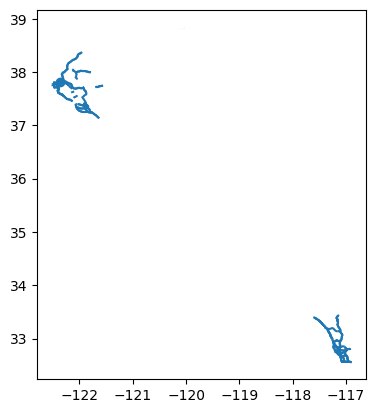

In [126]:
cordon_gdf.plot()